In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from os import makedirs
from os.path import join, exists, expanduser
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.applications.imagenet_utils import decode_predictions

/Users/neha/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


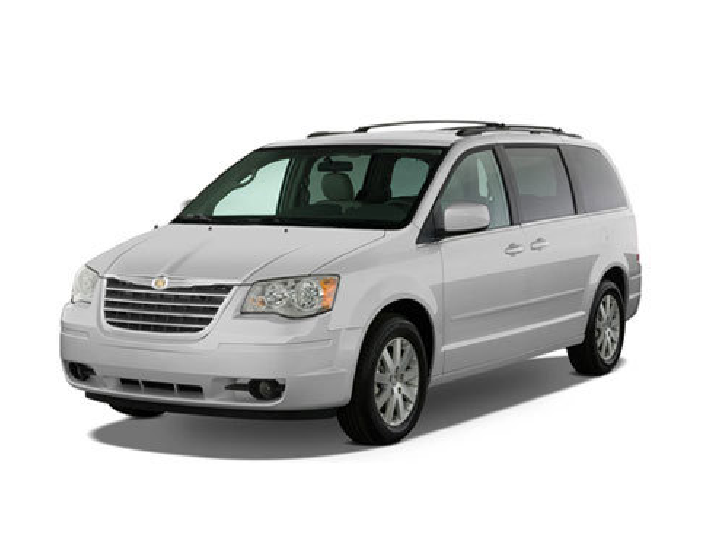

In [3]:
# read an example image
fig, ax = plt.subplots(1, figsize=(12, 10))
img = image.load_img('/Users/neha/Downloads/data/to_train/00006_vehicle.jpg')
img = image.img_to_array(img)
ax.imshow(img / 255.) 
ax.axis('off')
plt.show()

In [4]:
# use keras model with pre-trained weights
resnet = ResNet50(weights='imagenet', include_top=False, input_shape= (224,224,3))

/Users/neha/anaconda3/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [5]:
# creating car classifier using resnet50
from keras import Sequential
from keras.layers import Dense, Activation, Flatten

model = Sequential()
model.add(resnet)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               25690368  
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 49,278,337
Trainable params: 49,225,217
Non-trainable params: 53,120
_________________________________________________________________


In [6]:
# we will use RMSprop with learning rate .0001 and binary_crossentropy for binary classification
from keras import optimizers
model.compile(loss='binary_crossentropy', optimizer= optimizers.RMSprop(lr=2e-5), metrics=['accuracy'])

In [7]:
import os

data_path = '/Users/neha/Downloads/data/'
data_dir_list = os.listdir(data_path)

img_data_list=[]
labels = []
for dataset in data_dir_list:
    img_list=os.listdir(data_path+'/'+ dataset)
    print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
    for img in img_list:
        if 'not_vehicle' in img :
            labels.append(0)
        else : 
            labels.append(1)     
        img_path = data_path + '/'+ dataset + '/'+ img 
        img = image.load_img(img_path, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        img_data_list.append(x)
        

img_data = np.array(img_data_list)
#img_data = img_data.astype('float32')
print (img_data.shape)
img_data=np.rollaxis(img_data,1,0)
print (img_data.shape)
img_data=img_data[0]
print (img_data.shape)

Loaded the images of dataset-to_train

(51, 1, 224, 224, 3)
(1, 51, 224, 224, 3)
(51, 224, 224, 3)


In [8]:
# create tarining and test set
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
x,y = shuffle(img_data,labels, random_state=2)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)

/Users/neha/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [9]:
# training the model
import time

t=time.time()
hist = model.fit(X_train, y_train, batch_size=6000, epochs=12, verbose=1, validation_data=(X_test, y_test))
print('Training time: %s' % (t - time.time()))
(loss, accuracy) = model.evaluate(X_test, y_test, batch_size=10, verbose=1)

print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))

Train on 40 samples, validate on 11 samples
Epoch 1/12
40/40 [==============================] - 40s 988ms/step - loss: 0.8515 - acc: 0.5000 - val_loss: 0.0237 - val_acc: 1.0000
Epoch 2/12
40/40 [==============================] - 31s 786ms/step - loss: 0.0039 - acc: 1.0000 - val_loss: 0.0094 - val_acc: 1.0000
Epoch 3/12
40/40 [==============================] - 31s 777ms/step - loss: 6.6274e-05 - acc: 1.0000 - val_loss: 0.0090 - val_acc: 1.0000
Epoch 4/12
40/40 [==============================] - 30s 762ms/step - loss: 5.3268e-05 - acc: 1.0000 - val_loss: 0.0088 - val_acc: 1.0000
Epoch 5/12
40/40 [==============================] - 30s 757ms/step - loss: 4.4779e-05 - acc: 1.0000 - val_loss: 0.0086 - val_acc: 1.0000
Epoch 6/12
40/40 [==============================] - 30s 758ms/step - loss: 3.8592e-05 - acc: 1.0000 - val_loss: 0.0084 - val_acc: 1.0000
Epoch 7/12
40/40 [==============================] - 30s 748ms/step - loss: 3.3992e-05 - acc: 1.0000 - val_loss: 0.0083 - val_acc: 1.0000
Epoch

[[0.08410182]]


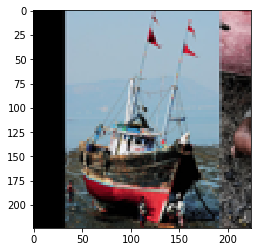

In [16]:
# try an example with training dataset
img = image.load_img('/Users/neha/Downloads/vehicles_test/4593_not_vehicle.jpg', target_size=(224, 224))
img = image.img_to_array(img)
plt.imshow(img / 255.)
x = preprocess_input(np.expand_dims(img.copy(), axis=0))
preds = model.predict(x)
print(preds)